<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available. 

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [30]:
# !pip install torch torchvision torchaudio --upgrade

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# For NLP, PyTorch users often leverage torchtext or Hugging Face's transformers.
# Example: from torchtext.data import Field, TabularDataset, BucketIterator
# or from transformers import BertTokenizer, BertModel

print("PyTorch version:", torch.__version__)
# If you decide to use transformers for NLP tasks, you can also print its version.
# Example: import transformers
# print("Transformers version:", transformers.__version__)


PyTorch version: 1.13.0


# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [2]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [5]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [6]:
df_train

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Preprocess the data

In [7]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

BATCH_SIZE = 32
# Assuming df_train is a pandas DataFrame containing your training data
NUM_TRAINING_EXAMPLES = len(df_train)
TRAIN_SIZE = int(NUM_TRAINING_EXAMPLES * 0.8)
VAL_SIZE = NUM_TRAINING_EXAMPLES - TRAIN_SIZE
# Steps per epoch in PyTorch are usually derived during the data loading phase,
# but you can calculate it similarly if needed for logging or custom loops.
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VAL_SPLIT = 0.2
EPOCHS = 2
# In PyTorch, DataLoader manages data loading, and you can specify the number of worker threads
# for parallel data loading with the `num_workers` argument. The optimal number depends on your system
# and the specific task. For many cases, setting it to the number of available CPU cores works well.

# Assuming you have a PyTorch Dataset for your data, you would split it like this:
# dataset = YourDataset(df_train, transform=transforms.ToTensor())
# train_dataset, val_dataset = random_split(dataset, [TRAIN_SIZE, VAL_SIZE])

# Then, create DataLoaders for training and validation:
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [8]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]



In [9]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [10]:
# # Load a DistilBERT model.
# preset= "distil_bert_base_en_uncased"

# # Use a shorter sequence length.
# preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
#                                                                    sequence_length=160,
#                                                                    name="preprocessor_4_tweets"
#                                                                   )

# # Pretrained classifier.
# classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
#                                                                preprocessor = preprocessor, 
#                                                                num_classes=2)

# classifier.summary()

In [11]:
# !pip install transformers

In [12]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the tokenizer and model from Hugging Face Transformers
preset = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(preset)

# Load a sequence classification model
model = AutoModelForSequenceClassification.from_pretrained(preset, num_labels=2)

# If you need to customize the sequence length, you can do so during tokenization
sequence_length = 160

# Example of tokenizing a text
text = "Replace this with your text"
inputs = tokenizer(text, max_length=sequence_length, truncation=True, padding="max_length", return_tensors="pt")

# To view the model's summary, you can print the model object
print(model)

c:\Users\itay8\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\itay8\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [21]:
inputs

{'input_ids': tensor([[ 101, 5672, 2023, 2007, 2115, 3793,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,

# Train your own model, fine-tuning BERT

In [13]:
# # Compile
# classifier.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
#     optimizer=keras.optimizers.Adam(1e-5),
#     metrics= ["accuracy"]  
# )

# # Fit
# history = classifier.fit(x=X_train,
#                          y=y_train,
#                          batch_size=BATCH_SIZE,
#                          epochs=EPOCHS, 
#                          validation_data=(X_val, y_val)
#                         )

In [14]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize data
def tokenize_data(texts, tokenizer, max_length=160):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")


In [15]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        try:
            # print(f"Accessing index: {idx}")  # Debug print
            text = self.texts[idx]
            inputs = self.tokenizer(text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
            
            return {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }
        except Exception as e:
            print(f"Error with index {idx}: {e}")
            raise



# Convert lists of texts and labels into tensors
# Assuming X_train, y_train, X_val, y_val are lists of texts and corresponding labels
max_length = 160  # or any value suitable for your needs

train_dataset = TextDataset(X_train, y_train, tokenizer, max_length)

# # Test __getitem__ manually
# test_idx = 0  # Try with different indices
# item = train_dataset.__getitem__(test_idx)
# print(item)
val_dataset = TextDataset(X_val, y_val, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [26]:
X_train.shape

(6090,)

In [30]:
train_dataset.__getitem__(2)

{'input_ids': tensor([  101,  2425,  1030, 13857, 16429,  8067,  2000, 24501, 15459,  2094,
          6665,  1997,  1005,  3932,  1005,  2445,  2000,  2149,  3548,  2012,
          1996,  9288,  1997,  5303,  6181,  1012,  3696,  2085,  1004, 23713,
          1025, 19387,   999, 16770,  1024,  1013,  1013,  1056,  1012,  2522,
          1013,  1057,  2549,  2099,  2620, 13626, 17922,  6305,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [36]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Assuming model is your DistilBertForSequenceClassification instance
# and tokenizer is your DistilBertTokenizer instance

# Define the optimizer
optimizer = Adam(model.parameters(), lr=1e-5)

# Define the loss function
loss_fn = CrossEntropyLoss()

# Assuming X_train, y_train, X_val, y_val are all available as PyTorch datasets or DataLoader instances
# Note: You will need to tokenize your text data and convert labels to tensor before this step

# Training loop
model.train()  # Set the model to training mode
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:  # Assuming train_loader is your DataLoader instance for training data
        optimizer.zero_grad()  # Clear previous gradients
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")
    
# Validation loop
model.eval()  # Set the model to evaluation mode
total_val_loss = 0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in val_loader:  # Assuming val_loader is your DataLoader instance for validation data
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        
        # Compute validation loss
        val_loss = loss_fn(outputs.logits, labels)
        total_val_loss += val_loss.item()
        
        # Compute accuracy
        preds = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate average validation loss and accuracy
avg_val_loss = total_val_loss / len(val_loader)
val_accuracy = correct_predictions / total_predictions

print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Reset model back to training mode after validation phase
model.train()

Accessing index: 1533
Accessing index: 2253
Accessing index: 5321
Accessing index: 1512
Accessing index: 4307
Accessing index: 723
Accessing index: 1166
Accessing index: 667
Accessing index: 466
Accessing index: 1149
Accessing index: 4502
Accessing index: 3655
Accessing index: 32
Accessing index: 2203
Accessing index: 4378
Accessing index: 5401
Accessing index: 2861
Accessing index: 1207
Accessing index: 490
Accessing index: 6011
Accessing index: 1890
Accessing index: 4592
Accessing index: 1781
Accessing index: 4094
Accessing index: 4110
Accessing index: 2505
Accessing index: 5977
Accessing index: 4816
Accessing index: 5211
Accessing index: 1223
Accessing index: 4773
Accessing index: 1306
Accessing index: 3501
Accessing index: 234
Accessing index: 5647
Accessing index: 4801
Accessing index: 3886
Accessing index: 4037
Accessing index: 1363
Accessing index: 3209
Accessing index: 5148
Accessing index: 1304
Accessing index: 3803
Accessing index: 5495
Accessing index: 6061
Accessing index: 

KeyboardInterrupt: 

In [11]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step


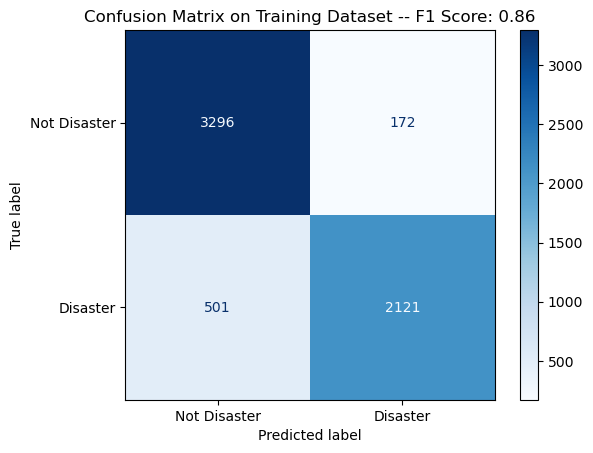

In [12]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step


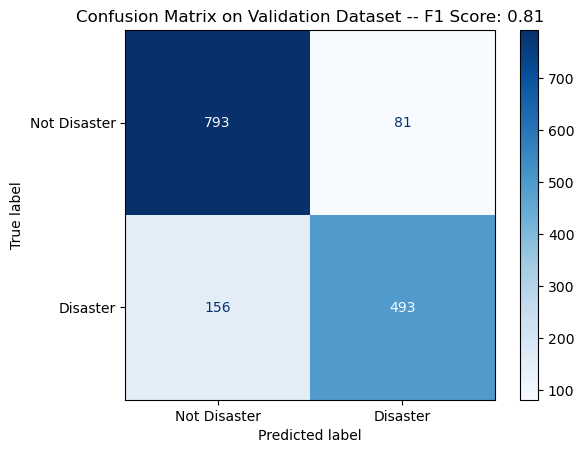

In [13]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Generate the submission file 

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [14]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [15]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step


In [16]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.361630
std,3146.427221,0.480546
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [17]:
sample_submission.to_csv("submission.csv", index=False)